In [312]:
import numpy as np
from scipy import misc
from skimage.transform import radon as lib_radon
from skimage.transform import iradon as lib_iradon
import cv2
import matplotlib.pyplot as plt
import sewar
%matplotlib inline

(480, 480)


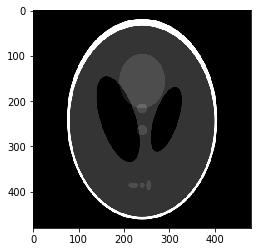

In [205]:
img = cv2.imread("../images/phantom.png",0)
print(img.shape)
plt.imshow(img, cmap="gray")

In [233]:
def radon(img, steps, circle=False):
    
    if(circle == False):
        #padding the given img
        diagonal = int(np.ceil(np.sqrt(2) * img.shape[0]))
        pad = diagonal - img.shape[0]
        old_center = img.shape[0] // 2
        new_center = diagonal // 2
        pad_before = new_center - old_center
        pad_width = ((pad_before, pad - pad_before),(pad_before, pad - pad_before))
        padded_img = np.pad(img, pad_width, mode='constant', constant_values=0)
    else:
        padded_img = img

    sinogram = np.zeros((padded_img.shape[0], steps), dtype=np.float64)

    for step in range(steps):
        rotation = misc.imrotate(padded_img, -step*180/steps).astype('float64')
        sinogram[:,step] = sum(rotation)
    
    #for debugging
    #plt.imshow(sinogram, cmap='gray')
    #print(sinogram.shape)
    
    return sinogram

In [234]:
def compute_quality_metrics(original_image, estimated_image):
    print('RMSE: %.4g' % sewar.full_ref.rmse(original_image,estimated_image))
    print('SSIM: %.4g' % sewar.full_ref.ssim(original_image,estimated_image)[0])
    print('PSNR: %.4g' % sewar.full_ref.psnr(original_image,estimated_image))
    print('UQI: %.4g' % sewar.full_ref.uqi(original_image,estimated_image))
    print('SCC: %.4g' % sewar.full_ref.scc(original_image,estimated_image))

In [242]:
def iradon(sinogram):
    
    #filtering fft of sinogram
    f = np.fft.fftfreq(sinogram.shape[0]).reshape(-1, 1)
    ramp_filter = 2 * np.abs(f)
    projection = np.fft.fft(sinogram, axis=0) * ramp_filter
    radon_filtered = np.real(np.fft.ifft(projection, axis=0))
    
    size = radon_filtered.shape[0]
    reconstructed = np.zeros((size, size))
    mid_index = size // 2
    [X, Y] = np.mgrid[0:size, 0:size]
    xpr = X - int(size) // 2
    ypr = Y - int(size) // 2
    x = np.arange(size) - mid_index
    
    theta = np.linspace(0., 180., sinogram.shape[1], endpoint=False) #0 to 180
    th = (np.pi / 180.0) * theta #0 to 3.14
    
    for i in range(len(theta)):
        t = ypr * np.cos(th[i]) - xpr * np.sin(th[i])
        backprojected = np.interp(t, x, radon_filtered[:, i], left=0, right=0)
        reconstructed += backprojected
        
    radius = size // 2
    reconstruction_circle = (xpr ** 2 + ypr ** 2) <= radius ** 2
    reconstructed[~reconstruction_circle] = 0
    out = reconstructed * np.pi / (2 * len(th))
    #plt.imshow(out, cmap='gray')
    
    #removing the excess padding the given img
    org_size = int(np.floor(size/np.sqrt(2)))
    crop = size - org_size
    crop_left = crop // 2
    crop_right = crop - crop_left
    crop_out = out[crop_left:-crop_right:,crop_left:-crop_right]
    #plt.imshow(crop_out,cmap='gray')
    np.clip(crop_out, 0, 255, out=crop_out)
    return crop_out
    

In [348]:
def art(sinogram, lmda = 1, n_iter = 100):
    size = sinogram.shape[0]
    theta = sinogram.shape[1]
    org_size = int(np.floor(size/np.sqrt(2)))
    
    x = np.zeros((org_size,org_size), dtype='float64')
    ATA =  iradon(radon(np.ones((org_size,org_size),dtype='uint8')*255,theta))+0.0001
    
    for i in log_progress(range(n_iter), every=1):
        x+=lmda*iradon((sinogram - radon(x,theta)))/ATA
    return x

In [343]:
def lib_art(sinogram, lmda = 1, n_iter = 100):
    size = sinogram.shape[0]
    theta = np.linspace(0., 180., sinogram.shape[1], endpoint=False)
    org_size = int(np.floor(size/np.sqrt(2)))
    
    x = np.zeros((org_size,org_size), dtype='float64')
    ATA =  lib_iradon(lib_radon(np.ones((org_size,org_size),dtype='uint8')*255,theta=theta,circle=False),theta=theta,circle=False)
    
    for i in log_progress(range(n_iter),every=1):
        x+=lmda*lib_iradon((sinogram - lib_radon(x,theta=theta,circle=False)),theta=theta,circle=False)/ATA

    return x

In [349]:
s = radon(img,30)
r = iradon(s)
a = art(s,1,500)

A Jupyter Widget

In [345]:
la = lib_art(s,1,500)
np.clip(la,0,255,out=la)

A Jupyter Widget

array([[  2.69061595,   3.51455835,   2.76653863, ...,   3.39664266,
          4.03697225,   2.8285358 ],
       [  3.99227964,   9.05296204,   7.53131837, ...,   8.74460498,
         10.02498255,   4.03681471],
       [  3.72466973,   8.55396266,   6.84695115, ...,   7.89239366,
          8.91414519,   3.51232361],
       ..., 
       [  2.1460638 ,   5.45121258,   4.55610597, ...,   3.63192199,
          4.49457633,   1.59866504],
       [  2.92074466,   7.239615  ,   5.94437232, ...,   5.15529063,
          6.3279206 ,   2.53173651],
       [  2.54522717,   3.53651838,   2.88877561, ...,   2.7221962 ,
          3.20906743,   2.30999886]])

In [390]:
a.max()
c=(a/a.max())*255

Text(0.5,1,'diff lib_art')

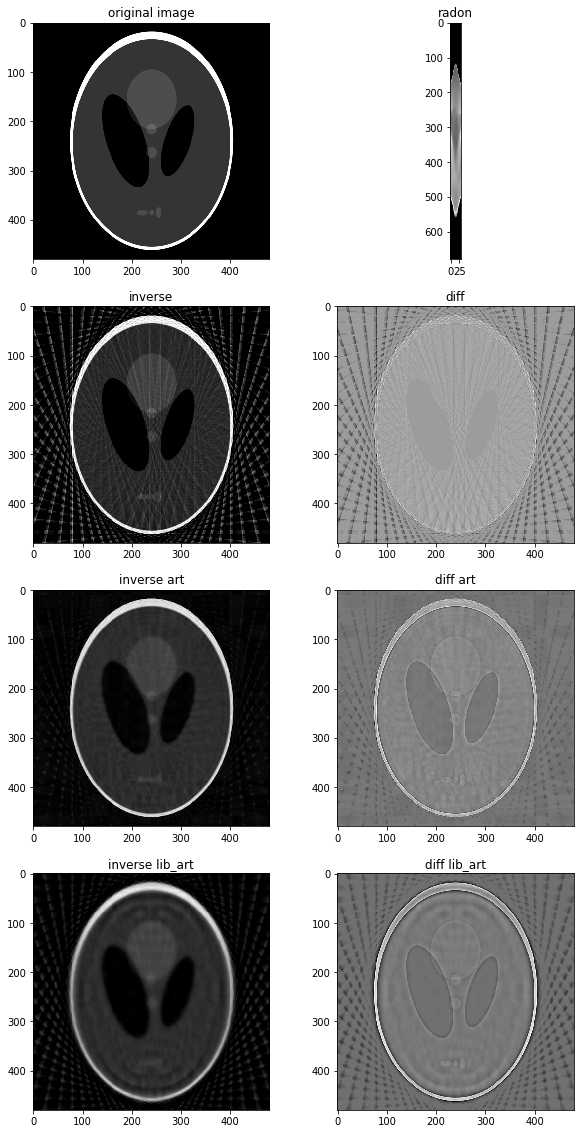

In [392]:
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [10, 20]

plt.subplot(421)
plt.imshow(img,cmap='gray', vmin = 0, vmax = 255)
plt.title("original image")

plt.subplot(422)
plt.imshow(s,cmap='gray')
plt.title("radon")

plt.subplot(423)
plt.imshow(r,cmap='gray', vmin = 0, vmax = 255)
plt.title("inverse")

plt.subplot(424)
plt.imshow(img-r,cmap='gray')
plt.title("diff")

plt.subplot(425)
plt.imshow(c,cmap='gray', vmin = 0, vmax = 255)
plt.title("inverse art")

plt.subplot(426)
plt.imshow(img-c,cmap='gray')
plt.title("diff art")

plt.subplot(427)
plt.imshow(la,cmap='gray', vmin = 0, vmax = 255)
plt.title("inverse lib_art")

plt.subplot(428)
plt.imshow(img-la,cmap='gray')
plt.title("diff lib_art")

In [393]:
print('fbp')
compute_quality_metrics(img,r)
print('art')
compute_quality_metrics(img,c)
print('libart')
compute_quality_metrics(img,la)

fbp
RMSE: 25.51
SSIM: 0.4079
PSNR: 20
UQI: 0.4509
SCC: 0.09833
art
RMSE: 13.86
SSIM: 0.4855


/home/darshan3/anaconda3/lib/python3.6/site-packages/sewar/utils.py:16: UserWarning: Supplied images have different dtypes uint8 and float64
  warnings.warn(msg)


PSNR: 25.3
UQI: 0.4565
SCC: 0.08649
libart
RMSE: 21.73
SSIM: 0.5201
PSNR: 21.39
UQI: 0.4437
SCC: 0.08431


In [340]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

(480, 480)


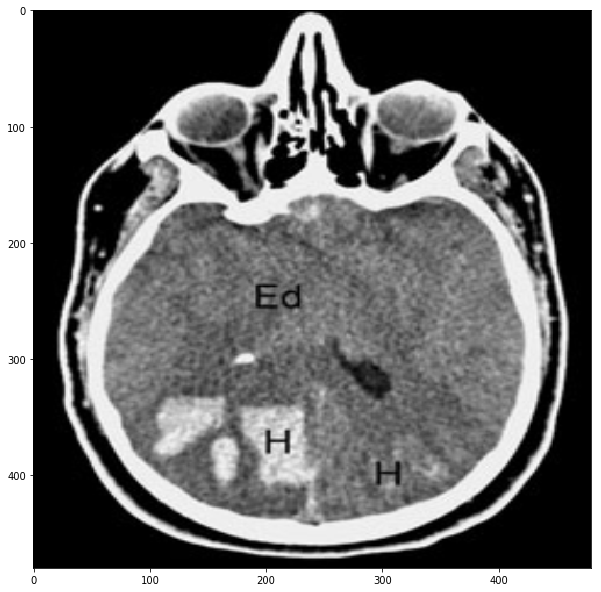

In [352]:
img1 = cv2.imread("../images/brain.png",0)
img1 = cv2.resize(img1,(480,480))
print(img1.shape)
plt.imshow(img1, cmap="gray")

In [353]:
s1 = radon(img1,30)
r1 = iradon(s1)
a1 = art(s1,1,500)
la1 = lib_art(s1,1,500)
np.clip(la1,0,255,out=la1)

A Jupyter Widget

A Jupyter Widget

array([[  4.60639761,   5.06191481,   2.97194508, ...,   0.11358716,
          1.58689268,   2.06978257],
       [  6.37800588,  13.45663917,   9.51046315, ...,   1.88503132,
          5.03894197,   2.63447117],
       [  5.36365254,  12.22947881,   8.77531237, ...,   1.91344071,
          4.28822598,   1.90566198],
       ..., 
       [  0.44200192,   1.53583838,   0.57192328, ...,  12.36470428,
          8.65519116,   1.46210873],
       [  1.07334926,   2.89887923,   1.31561117, ...,  14.67626245,
         12.33483125,   3.17195405],
       [  1.18876814,   0.95637695,   0.        , ...,   5.83616351,
          5.35994677,   2.83447824]])

In [394]:
c1=(a1/a1.max())*255

Text(0.5,1,'diff lib_art')

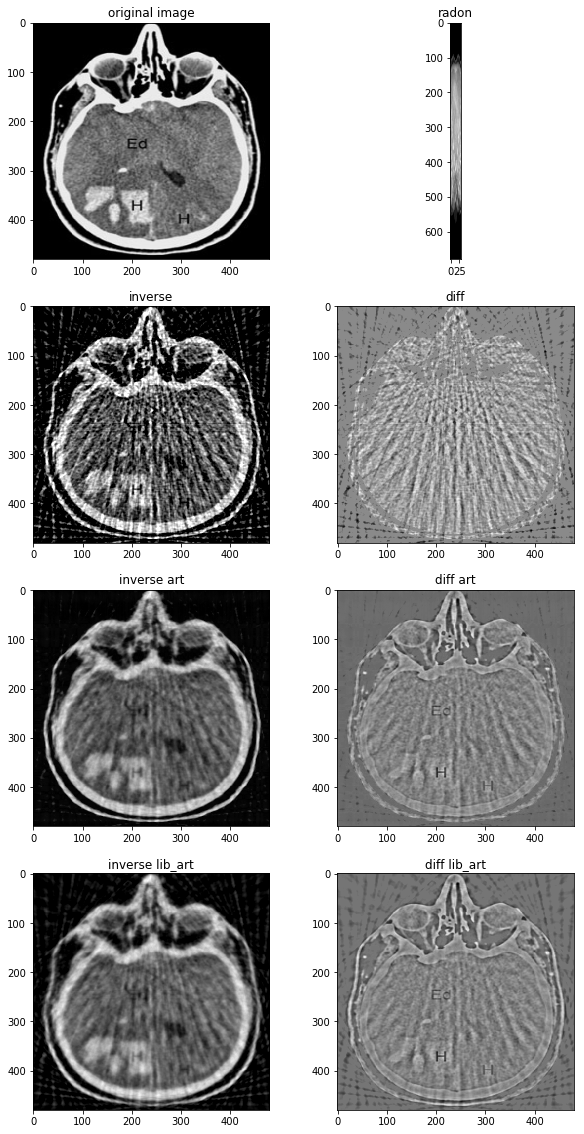

In [396]:
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [10, 20]

plt.subplot(421)
plt.imshow(img1,cmap='gray', vmin = 0, vmax = 255)
plt.title("original image")

plt.subplot(422)
plt.imshow(s1,cmap='gray')
plt.title("radon")

plt.subplot(423)
plt.imshow(r1,cmap='gray', vmin = 0, vmax = 255)
plt.title("inverse")

plt.subplot(424)
plt.imshow(img1-r1,cmap='gray')
plt.title("diff")

plt.subplot(425)
plt.imshow(c1,cmap='gray', vmin = 0, vmax = 255)
plt.title("inverse art")

plt.subplot(426)
plt.imshow(img1-c1,cmap='gray')
plt.title("diff art")

plt.subplot(427)
plt.imshow(la1,cmap='gray', vmin = 0, vmax = 255)
plt.title("inverse lib_art")

plt.subplot(428)
plt.imshow(img1-la1,cmap='gray')
plt.title("diff lib_art")

In [397]:
print('fbp')
compute_quality_metrics(img1,r1)
print('art')
compute_quality_metrics(img1,c1)
print('libart')
compute_quality_metrics(img1,la1)

fbp
RMSE: 42.58
SSIM: 0.3757
PSNR: 15.55
UQI: 0.5936
SCC: 0.2109
art
RMSE: 31.34


/home/darshan3/anaconda3/lib/python3.6/site-packages/sewar/utils.py:16: UserWarning: Supplied images have different dtypes uint8 and float64
  warnings.warn(msg)


SSIM: 0.4885
PSNR: 18.21
UQI: 0.6496
SCC: 0.2372
libart
RMSE: 31.7
SSIM: 0.45
PSNR: 18.11
UQI: 0.6475
SCC: 0.2337


In [361]:
def scaled_art(sinogram, lmda = 1, n_iter = 100):
    size = sinogram.shape[0]
    theta = sinogram.shape[1]
    org_size = int(np.floor(size/np.sqrt(2)))
    
    x = np.zeros((org_size,org_size), dtype='float64')
    ATA =  (iradon(radon(np.ones((org_size,org_size),dtype='uint8')*255,theta))/(np.pi/(2*theta)))+0.0001
    
    for i in log_progress(range(n_iter), every=1):
        x+=lmda*(iradon((sinogram - radon(x,theta)))/(np.pi/(2*theta)))/ATA
    return x

In [362]:
sa = scaled_art(s,1,500)

A Jupyter Widget

In [363]:
np.clip(sa,0,255,out=sa)

array([[ 0.        ,  5.11833251,  2.45026438, ...,  4.10610944,
         4.82558705,  6.34857101],
       [ 2.97113718,  2.98861378,  2.81367691, ...,  3.06129668,
         3.83512085,  2.40823133],
       [ 1.68699095,  2.37661542,  2.77655077, ...,  3.29338609,
         2.80581561,  2.07935644],
       ..., 
       [ 1.51066073,  2.15602959,  2.86532673, ...,  2.96516824,
         2.2758612 ,  2.01220266],
       [ 1.57022948,  2.99051375,  2.41156424, ...,  2.65105405,
         3.09132542,  2.03657147],
       [ 4.53804938,  3.7187075 ,  2.71174566, ...,  2.10723121,
         2.87397719,  3.36700971]])

Text(0.5,1,'diff')

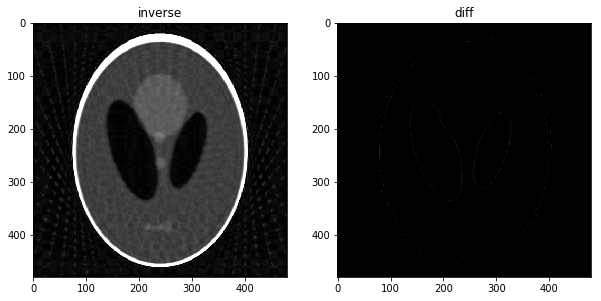

In [377]:
plt.subplot(121)
plt.imshow(2.5*sa,cmap='gray', vmin = 0, vmax = 255)
plt.title("inverse")

plt.subplot(122)
plt.imshow(img-2.5*sa,cmap='gray', vmin = 0, vmax = 255)
plt.title("diff")